<a href="https://colab.research.google.com/github/JiaxinLi-lipluszn/Temp_notebooks/blob/main/Attention_Map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os 
os.chdir("/content/drive/MyDrive/DINO_Group/128+128_TS/")

In [ ]:
import os
import sys
import argparse
import cv2
import random
import colorsys
import requests
from io import BytesIO

import skimage.io
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image

In [ ]:
import utils
import vision_transformer as vits

In [ ]:
model = vits.vit_tiny()  
for p in model.parameters():
        p.requires_grad = False
model.eval()


VisionTransformer(
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=256, out_features=768, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=256, out_features=1024, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=1024, out_features=256, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=256, out_fe

In [ ]:
state_dict = torch.load("./128+128/checkpoint0335.pth", map_location="cpu")

state_dict = state_dict["teacher"]
# remove `module.` prefix
state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
# remove `backbone.` prefix induced by multicrop wrapper
state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
msg = model.load_state_dict(state_dict, strict=False)
print('Pretrained weights found at {} and loaded with msg: {}'.format("./128+128/checkpoint0335.pth", msg))

Pretrained weights found at ./128+128/checkpoint0335.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


In [ ]:
label = 1
file_name = "1005.png"

# Run all

In [ ]:
img = Image.open(f"/content/drive/MyDrive/data/val/{label}/{file_name}")

FileNotFoundError: ignored

In [ ]:
img

In [ ]:
gray = pth_transforms.Grayscale(img)


In [ ]:
class Crop_No_shuffle(object):
  def __init__(self, global_crops_scale):
    self.global_crops_scale = global_crops_scale
    self.totensor = pth_transforms.ToTensor()
  def __call__(self, x):
    data = self.totensor(x)
    data = torch.flatten(data)  
    global_size = int(784 * self.global_crops_scale)
    global_index_1 = np.arange(784)
    global_corr_1 = torch.from_numpy(global_index_1)
    global_data_1 = data[global_index_1,]
    global_input_1 = torch.cat([global_data_1, global_corr_1]).float()
    return global_input_1

In [ ]:
crop = Crop_No_shuffle(1)

In [ ]:
image_tensor = crop(img)

In [ ]:
image_tensor = image_tensor.reshape(1, 1568).cuda()
model = model.cuda()

In [ ]:
attentions = model.get_last_selfattention(image_tensor)


In [ ]:
attentions.shape

torch.Size([1, 1, 785, 785])

In [ ]:
# we keep only the output patch attention
nh = attentions.shape[1]
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)


In [ ]:
attentions.shape

torch.Size([1, 784])

In [ ]:
attention = attentions.reshape(1,28,28).cpu().detach().numpy()

In [ ]:
saved_img = image_tensor[:,0:784].reshape(28,28)

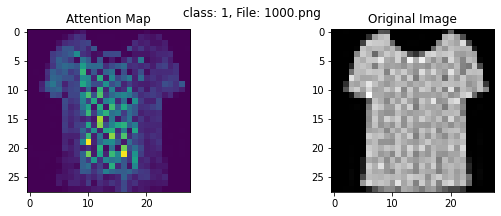

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].imshow(attention[0])
axs[0].set_title("Attention Map")
axs[1].imshow(saved_img.cpu(),cmap = 'gray')
axs[1].set_title("Original Image")
'''
for ax in axs:
    ax.imshow(attention[0],interpolation=interp)
'''
plt.suptitle(f"class: {label}, File: {file_name}")
plt.savefig(f"{label}_{file_name}",)
#plt.show()